In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import nibabel as nib
import glob
import shutil
from matplotlib import pyplot as plt
import numpy as np

In [ ]:

FONTSIZE=15
plt.figure()
fig, axs = plt.subplots(3, 5,figsize=(15,15))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0, hspace=0.05)

img = nib.load('data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_t1.nii.gz').get_data()
dim = img.shape

ax = axs[0,0]
ax.imshow(np.pad(np.rot90(img[round(dim[0]/2),:,:]),((42,43),(0,0)),'constant',constant_values=0), 
                cmap=plt.cm.gray)
ax.set_title('T1',fontsize=FONTSIZE)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Sagittal',fontsize=FONTSIZE)

ax = axs[1,0]
ax.imshow(np.pad(np.rot90(img[:,round(dim[1]/2),:]),((42,43),(0,0)),'constant',constant_values=0), 
                cmap=plt.cm.gray)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Coronal',fontsize=FONTSIZE)

ax = axs[2,0]
ax.imshow(np.rot90(img[:,:,round(dim[2]/2)]), cmap=plt.cm.gray)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Axial',fontsize=FONTSIZE)

files = ['','t2','flair','t1ce','seg']
titles = ['','T2','FLAIR','T1Gd','Ground Truth']
for i in range(1,5):
    img = nib.load('data/MICCAI_BraTS_2019_Data_Training/HGG/'+
                   'BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_{}.nii.gz'.format(files[i])).get_data()
    dim = img.shape

    ax = axs[0,i]
    ax.imshow(np.pad(np.rot90(img[round(dim[0]/2),:,:]),((42,43),(0,0)),'constant',constant_values=0), 
                    cmap=plt.cm.gray)
    ax.set_title(titles[i],fontsize=FONTSIZE)
    ax.axis('off')

    ax = axs[1,i]
    ax.imshow(np.pad(np.rot90(img[:,round(dim[1]/2),:]),((42,43),(0,0)),'constant',constant_values=0), 
                    cmap=plt.cm.gray)
    ax.axis('off')

    ax = axs[2,i]
    ax.imshow(np.rot90(img[:,:,round(dim[2]/2)]), cmap=plt.cm.gray)
    ax.axis('off')

fig.savefig('log/all_mods.png',dpi=200)

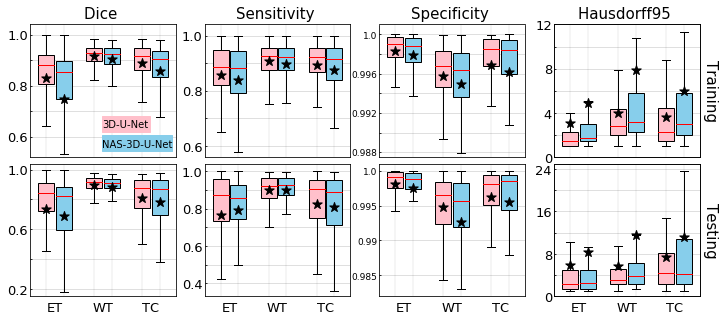

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

def metric_plot(csv_3dunet, csv_nas, csv_unet_test, csv_nas_test, save_name):
    df_3dunet = pd.read_csv(csv_3dunet)
    df_nas = pd.read_csv(csv_nas)
    df_unet_test = pd.read_csv(csv_unet_test)
    df_nas_test = pd.read_csv(csv_nas_test)
    metrics = list(df_nas.keys())[1:]
    FS = 6
    fig, axs = plt.subplots(2, 4, figsize=(FS*2,5),sharex=True)
    fig.subplots_adjust(#left=0.08, right=0.98, bottom=0.05, top=0.9,
                        hspace=0.05, wspace=0.2)
    
    for row in range(2):
        metric_i = 0
        df0 = df_3dunet if row == 0 else df_unet_test
        df1 = df_nas if row == 0 else df_nas_test
        for col in range(4):
            ax = axs[row,col]
            values = []
            labels = []
            positions = [0]
            means = []
            DIST = 0.55
            for metric in metrics[3*metric_i:3*(metric_i+1)]:
                for df in [df0, df1]:
                    values.append([x for x in df[metric][:-5] if not np.isnan(x)])
                    means.append(list(df[metric])[-5])
                    positions.append(positions[-1]+DIST)
                positions[-1] += 0.4
                labels += [metric.split('_')[-1]]
            positions = positions[:6]    
            box = ax.boxplot(values, positions=positions,
                             showfliers=False,showmeans=False,widths=0.5,
                             patch_artist=True,
                             notch=False,
                             medianprops={'linewidth':1,'color':'r'})
            colors = ['pink', 'skyblue']
            for i,bar in enumerate(box['boxes']):
                bar.set_facecolor(colors[i%2])
            ax.scatter(positions, means,
                         c='k', marker='*', s=100 ,zorder=10)
            ax.set_xticks([(positions[i*2]+positions[i*2+1])/2 for i in range(3)])
            ax.set_xticklabels(labels,size=14)
            
            if row == 0:
                ax.set_title('{} '.format(metric.split('_')[0]),size=15)
            ax.vlines(positions,0,30,alpha=0.8,linewidth=0.1)
            ax.yaxis.grid(True,alpha=0.5)
            ax.tick_params(bottom=False)
            ax.tick_params(axis='x',labelsize=13, pad=2)
            ax.tick_params(axis='y',labelsize=13, length=2, pad=2, direction='in')
            metric_i += 1
        ax_right = ax.twinx()
        ax_right.tick_params(right=False,labelright=False)
        ax_right.set_ylabel('Training' if row==0 else 'Testing', size=15, labelpad=18, rotation=270)

    
    ax = axs[0,0]
    offset_x = 1.15
    offset_y = 0.02
    ax.text(positions[-2]-offset_x, 0.62+offset_y, '3D-U-Net',
             backgroundcolor='pink', color='pink', weight='roman',
             size=9,)
    ax.text(positions[-2]-offset_x, 0.545+offset_y, '3D-NAS-U-Net',
             backgroundcolor='skyblue', color='skyblue', weight='roman',
             size=9,)
    ax.text(positions[-2]-offset_x-0.1, 0.615+offset_y, '3D-U-Net',
             color='k', weight='roman',
             size=10,)
    ax.text(positions[-2]-offset_x-0.1, 0.54+offset_y, 'NAS-3D-U-Net',
            color='k', weight='roman',
             size=10,)
    ax.set_ylim(0.52,1.04)
    ax.set_yticks([0.6,0.7,0.8,0.9,1.0])
    ax.set_yticklabels([0.6,'',0.8,'',1.0])

    ax = axs[0,1]
    ax.set_ylim(0.56,1.04)
    ax.set_yticks(np.arange(0.6,1.01,0.1))
    ax.set_yticklabels([0.6,'',0.8,'',1.0])

    ax = axs[0,2]
    ax.set_ylim(0.9875,1.001)
    ax.set_yticks(np.arange(0.988, 1.001, 0.002))
    ax.set_yticklabels([0.988,'',0.992,'',0.996,'',1.0], size=9)
    
    ax = axs[0,3]
    ax.set_ylim(0,12)
    ax.set_yticks(np.arange(0, 13, 2))
    ax.set_yticklabels([0,'',4,'',8,'',12],)
    
    ax = axs[1,0]
    ax.set_ylim(0.15,1.04)
    ax.set_yticks(np.arange(0.2,1.04,0.2))
    ax.set_yticklabels([0.2,'',0.6,'',1.0])


    ax = axs[1,1]
    ax.set_ylim(0.33,1.04)
    ax.set_yticks(np.arange(0.4,1.01,0.1))
    ax.set_yticklabels([0.4,'',0.6,'',0.8,'',1.0])

    ax = axs[1,2]
    ax.set_ylim(0.982,1.001)
    ax.set_yticks(np.arange(0.985, 1.001, 0.005))
    ax.set_yticklabels(np.arange(0.985, 1.001, 0.005),size=9)
    

    ax = axs[1,3]
    ax.set_ylim(0,25)
    ax.set_yticks(np.arange(0, 25, 4))
    ax.set_yticklabels([0,'',8,'',16,'',24],)
    
    
    plt.savefig(save_name,dpi=200)
    plt.show()

if __name__ == '__main__':
    csv_3dunet = 'data/results/Stats_Training_best_3dunet.csv'
    csv_nas = 'data/results/final_128_inclab_auto_latest/Stats_Training_final.csv'
    csv_unet_test = 'data/results/Stats_Validation_best_3dunet.csv'
    csv_nas_test = 'data/results/final_128_inclab_auto_latest/Stats_Validation_final.csv'
    metric_plot(csv_3dunet, csv_nas, csv_unet_test, csv_nas_test, 'log/metrics.png')
    

In [ ]:
csv_3dunet = 'data/results/Stats_Training_best_3dunet.csv'
csv_nas = 'data/results/final_128_inclab_auto_latest/Stats_Training_final.csv'
csv_unet_test = 'data/results/Stats_Validation_best_3dunet.csv'
csv_nas_test = 'data/results/final_128_inclab_auto_latest/Stats_Validation_final.csv'
import pandas as pd

df = pd.read_csv(csv_3dunet)
print(df.keys())
df.iloc[-5]